In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [3]:
base_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily_run'

In [4]:
### Adding the landcover data that I did the bankbuffer scenario with

landcover_bankbuffer = pd.read_csv(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\base_hsfiles_bankbuffer6m\inputs\WFK23_lcdata.csv')

In [5]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
#obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [6]:
notopo_shade_df = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily', 'outputs', 'Shade.csv'), skiprows=6,
         usecols=range(1, 185))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)

notopo_shade_df[(notopo_shade_df['NODE_ID'] <= 18.3) & (notopo_shade_df['NODE_ID']>=10)]


,NODE_ID,July Shade
0,18.3,0.4166
1,18.2,0.2887
2,18.1,0.3402
3,18.0,0.0712
4,17.9,0.0719
...,...,...
79,10.4,0.0533
80,10.3,0.0250
81,10.2,0.0546
82,10.1,0.2385


In [12]:
## Scenario Type
landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))

changed_nodes = {}

#for index, row in landcover.iterrows():
original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\500m_run\july_daily_run'
# folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
# new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\grassallnodes_update3" 
shutil.copytree(original_folder_path, new_folder_path)

control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

landcover_km = landcover.copy()# Create a copy of landcover DataFrame
morphology_km = morphology.copy()# Create a copy of morphology DataFrame
#landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
reach_shade = notopo_shade_df#[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
##print(km_start)
    #changed_nodes[km_start] = []

#loop to increase shade at each node, increase width only where its currently grassy

for index, row in reach_shade.iterrows():
    #assigns bankbuffer shade to each node
    landcover_km.loc[index, landcover_km.columns[8:48]] = 0
    landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)

    # only widens currently grassy nodes
    if reach_shade.loc[index]['July Shade'] > .2:
        print('narrow @: ', index)


        #if you want to only increase shade at previouslt grassy nodes, uncomment the below line
        # landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
        print(morphology_km.loc[index,morphology_km.columns[5]])
        #narrow currently forested reaches by 20% when changed to grass
        morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*.8
        print(morphology_km.loc[index,morphology_km.columns[5]])
        morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)            #morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            # changed_nodes[km_start].append(index)

os.chdir(new_folder_path)
subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

narrow @:  0
7.6
6.08
narrow @:  1
8.62547
6.9003760000000005
narrow @:  2
8.43756
6.750048
narrow @:  6
8.050775
6.44062
narrow @:  7
8.006215
6.404972
narrow @:  18
11.30933
9.047464
narrow @:  20
12.103625
9.6829
narrow @:  21
12.45262
9.962096
narrow @:  22
10.736615
8.589292
narrow @:  23
13.12657
10.501256
narrow @:  26
12.122345
9.697876
narrow @:  27
15.116355
12.093084000000001
narrow @:  28
13.936935
11.149548000000001
narrow @:  29
12.993975
10.395180000000002
narrow @:  30
16.043575
12.83486
narrow @:  31
18.604415
14.883532
narrow @:  33
15.057925
12.04634
narrow @:  34
14.02941
11.223528000000002
narrow @:  37
13.991785
11.193428
narrow @:  41
11.761795
9.409436
narrow @:  42
12.105625
9.6845
narrow @:  45
12.43039
9.944312
narrow @:  48
10.66504
8.532032
narrow @:  53
13.961175
11.168940000000001
narrow @:  54
15.80338
12.642704000000002
narrow @:  55
15.028385
12.022708000000002
narrow @:  56
14.894185
11.915348000000002
narrow @:  61
12.563015
10.050412000000001
narrow

CompletedProcess(args=['hs', 'run', '-t'], returncode=0)

In [8]:
base_tw_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
base_tw_df.columns = [float(col) for col in base_tw_df.columns]
base_tw_df.index = obs_clip.index
#mean july
mean_daily_base = base_tw_df.resample('D').max()
mean_july_base = base_tw_df.max()
mean_base = pd.DataFrame(mean_july_base)
mean_base = mean_base.reset_index()
mean_base.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_base['distance downstream'] = 18.3 - mean_base['NODE_ID']


allshade_tw_df = pd.read_csv(os.path.join(new_folder_path, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
allshade_tw_df.columns = [float(col) for col in allshade_tw_df.columns]
allshade_tw_df.index = obs_clip.index
#mean july
mean_allshade = allshade_tw_df.resample('D').max()
mean_allshade = mean_allshade.max()
mean_allshade

mean_allshade = pd.DataFrame(mean_allshade)
mean_allshade = mean_allshade.reset_index()
mean_allshade.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_allshade['distance downstream'] = 18.3 - mean_allshade['NODE_ID']


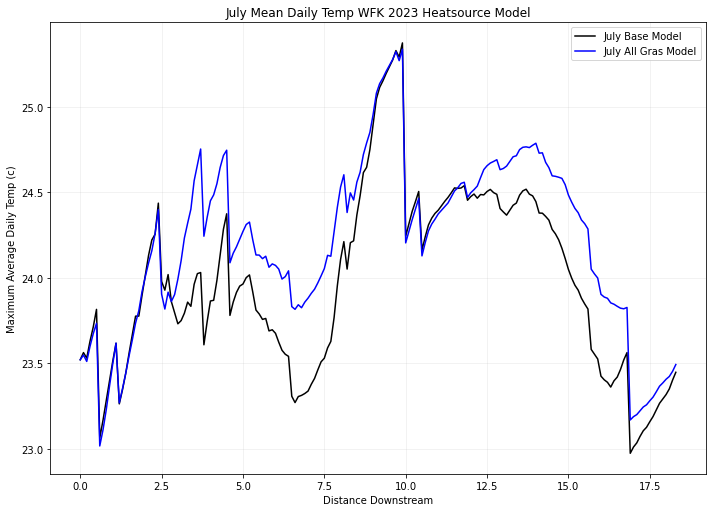

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(mean_base.index/10, mean_base['Mean'], label='July Base Model', color = 'black')
plt.plot(mean_allshade.index/10, mean_allshade['Mean'], label='July All Gras Model', color = 'blue')

#plt.plot(max_dailymean_scenario.index/10,max_dailymean_scenario['Max Daily Mean July Temp'],  label = 'Shade Scenario Model')


plt.ylabel('Maximum Average Daily Temp (c)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(21, 25)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('July Mean Daily Temp WFK 2023 Heatsource Model')
plt.savefig('JulyDailyMean_withobstribQ.png')
plt.show()


In [20]:
## Scenario Type
landcover = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\all_grass\grassallnodes', 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\all_grass\grassallnodes', 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata_notopo.csv'))

changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    #print("km_start:", km_start)
    landcover_km = landcover.copy()# Create a copy of landcover DataFrame
    morphology_km = morphology.copy()# Create a copy of morphology DataFrame
    if km_start == 18.3:
        km_end = 17.0
        # Defining new folders to write scenario outputs to
        original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\all_grass\grassallnodes'
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\reachbyreach\\addshade_{18.0}" 
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        

        # Assign shade value to specific range of columns for the current kilometer stretch
        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []
    
        #loop to increase shade at each node, increase width only where its currently grassy
        
        for index, row in reach_shade.iterrows():
            
            #assigns bankbuffer shade to each node
            landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            
            # only widens currently grassy nodes
            if reach_shade.loc[index]['July Shade'] < .2:
                print('widening @: ', index)

                
                #if you want to only increase shade at previouslt grassy nodes, uncomment the below line
                # landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
                
                #widening currently grassy reaches by 20% when changed to trees
                morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
                
                # landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
                #morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
                changed_nodes[km_start].append(index)

        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        #Widen nodes where shade is increase
        
        # morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]] = (morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]])*1.5
        # morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
        
        #running heatsource
#         os.chdir(new_folder_path)
#         subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        continue
#     # Check if 'STREAM_KM' is a float and ends with '.0'
    if isinstance(km_start, float) and km_start % 1 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        print(km_start)
        #print('true')
        if km_start == 18.0:
            continue
        km_end = km_start - 1  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\all_grass\grassallnodes'
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\reachbyreach\\addshade_{km_start}" 
        shutil.copytree(original_folder_path, new_folder_path) 

        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []
     #loop to increase shade at each node, increase width only where its currently grassy
        
        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)

            if reach_shade.loc[index]['July Shade'] < .2:
                print('widening @: ', index)

                
                #if you want to only increase shade at previouslt grassy nodes, uncomment the below line
                # landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
                
                #widening currently grassy reaches by 20% when changed to trees
                morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
                
                # landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
                #morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
                changed_nodes[km_start].append(index)

        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)



#         # Assign shade value to specific range of columns for the current kilometer stretch
#         landcover_km.loc[(landcover_km['STREAM_KM'] <= km_start) & (landcover_km['STREAM_KM'] >= km_end), landcover_km.columns[8:48]] = landcover_bankbuffer.loc[(landcover_bankbuffer['STREAM_KM'] <= km_start) & (landcover_bankbuffer['STREAM_KM'] >= km_end), landcover_bankbuffer.columns[8:48]]
#         landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
        
#         #widening the same nodes that are being shaded
#         morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]] = (morphology_km.loc[(morphology_km['STREAM_KM'] <= km_start) & (morphology_km['STREAM_KM'] >= km_end), morphology_km.columns[5]])*1.5
#         morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
#         #running heatsource
#         os.chdir(new_folder_path)
#         subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        
        #print("Modified DataFrame:", landcover_km)  # Check the modified DataFrame

# # Continue your script after this loop


18.3
widening @:  3
widening @:  4
widening @:  5
widening @:  8
widening @:  9
widening @:  10
widening @:  11
widening @:  12
widening @:  13
18.0
17.0
17.0
widening @:  13
widening @:  14
widening @:  15
widening @:  16
widening @:  17
widening @:  19
16.0
16.0
widening @:  24
widening @:  25
widening @:  32
15.0
15.0
widening @:  35
widening @:  36
widening @:  38
widening @:  39
widening @:  40
widening @:  43
14.0
14.0
widening @:  43
widening @:  44
widening @:  46
widening @:  47
widening @:  49
widening @:  50
widening @:  51
widening @:  52
13.0
13.0
widening @:  57
widening @:  58
widening @:  59
widening @:  60
12.0
12.0
widening @:  65
widening @:  66
widening @:  67
widening @:  68
widening @:  69
widening @:  71
widening @:  72
widening @:  73
11.0
11.0
widening @:  73
widening @:  74
widening @:  76
widening @:  78
widening @:  79
widening @:  80
widening @:  81
widening @:  83
10.0
10.0
widening @:  83
widening @:  84
widening @:  85
widening @:  87
widening @:  88
wid

In [15]:
df = pd.DataFrame({'value': list(changed_nodes.keys()), 'counts': [len(lst) for lst in changed_nodes.values()]})
df['Reach Start KM'] = 19 - (df.index+1)
#df['Reach Start KM'] = 19 -df['row_number']
changed_node_count = pd.merge(nodes, df[['Reach Start KM','counts']], left_on='row_number', right_on = 'Reach Start KM', how='left')
changed_node_count

NameError: name 'nodes' is not defined

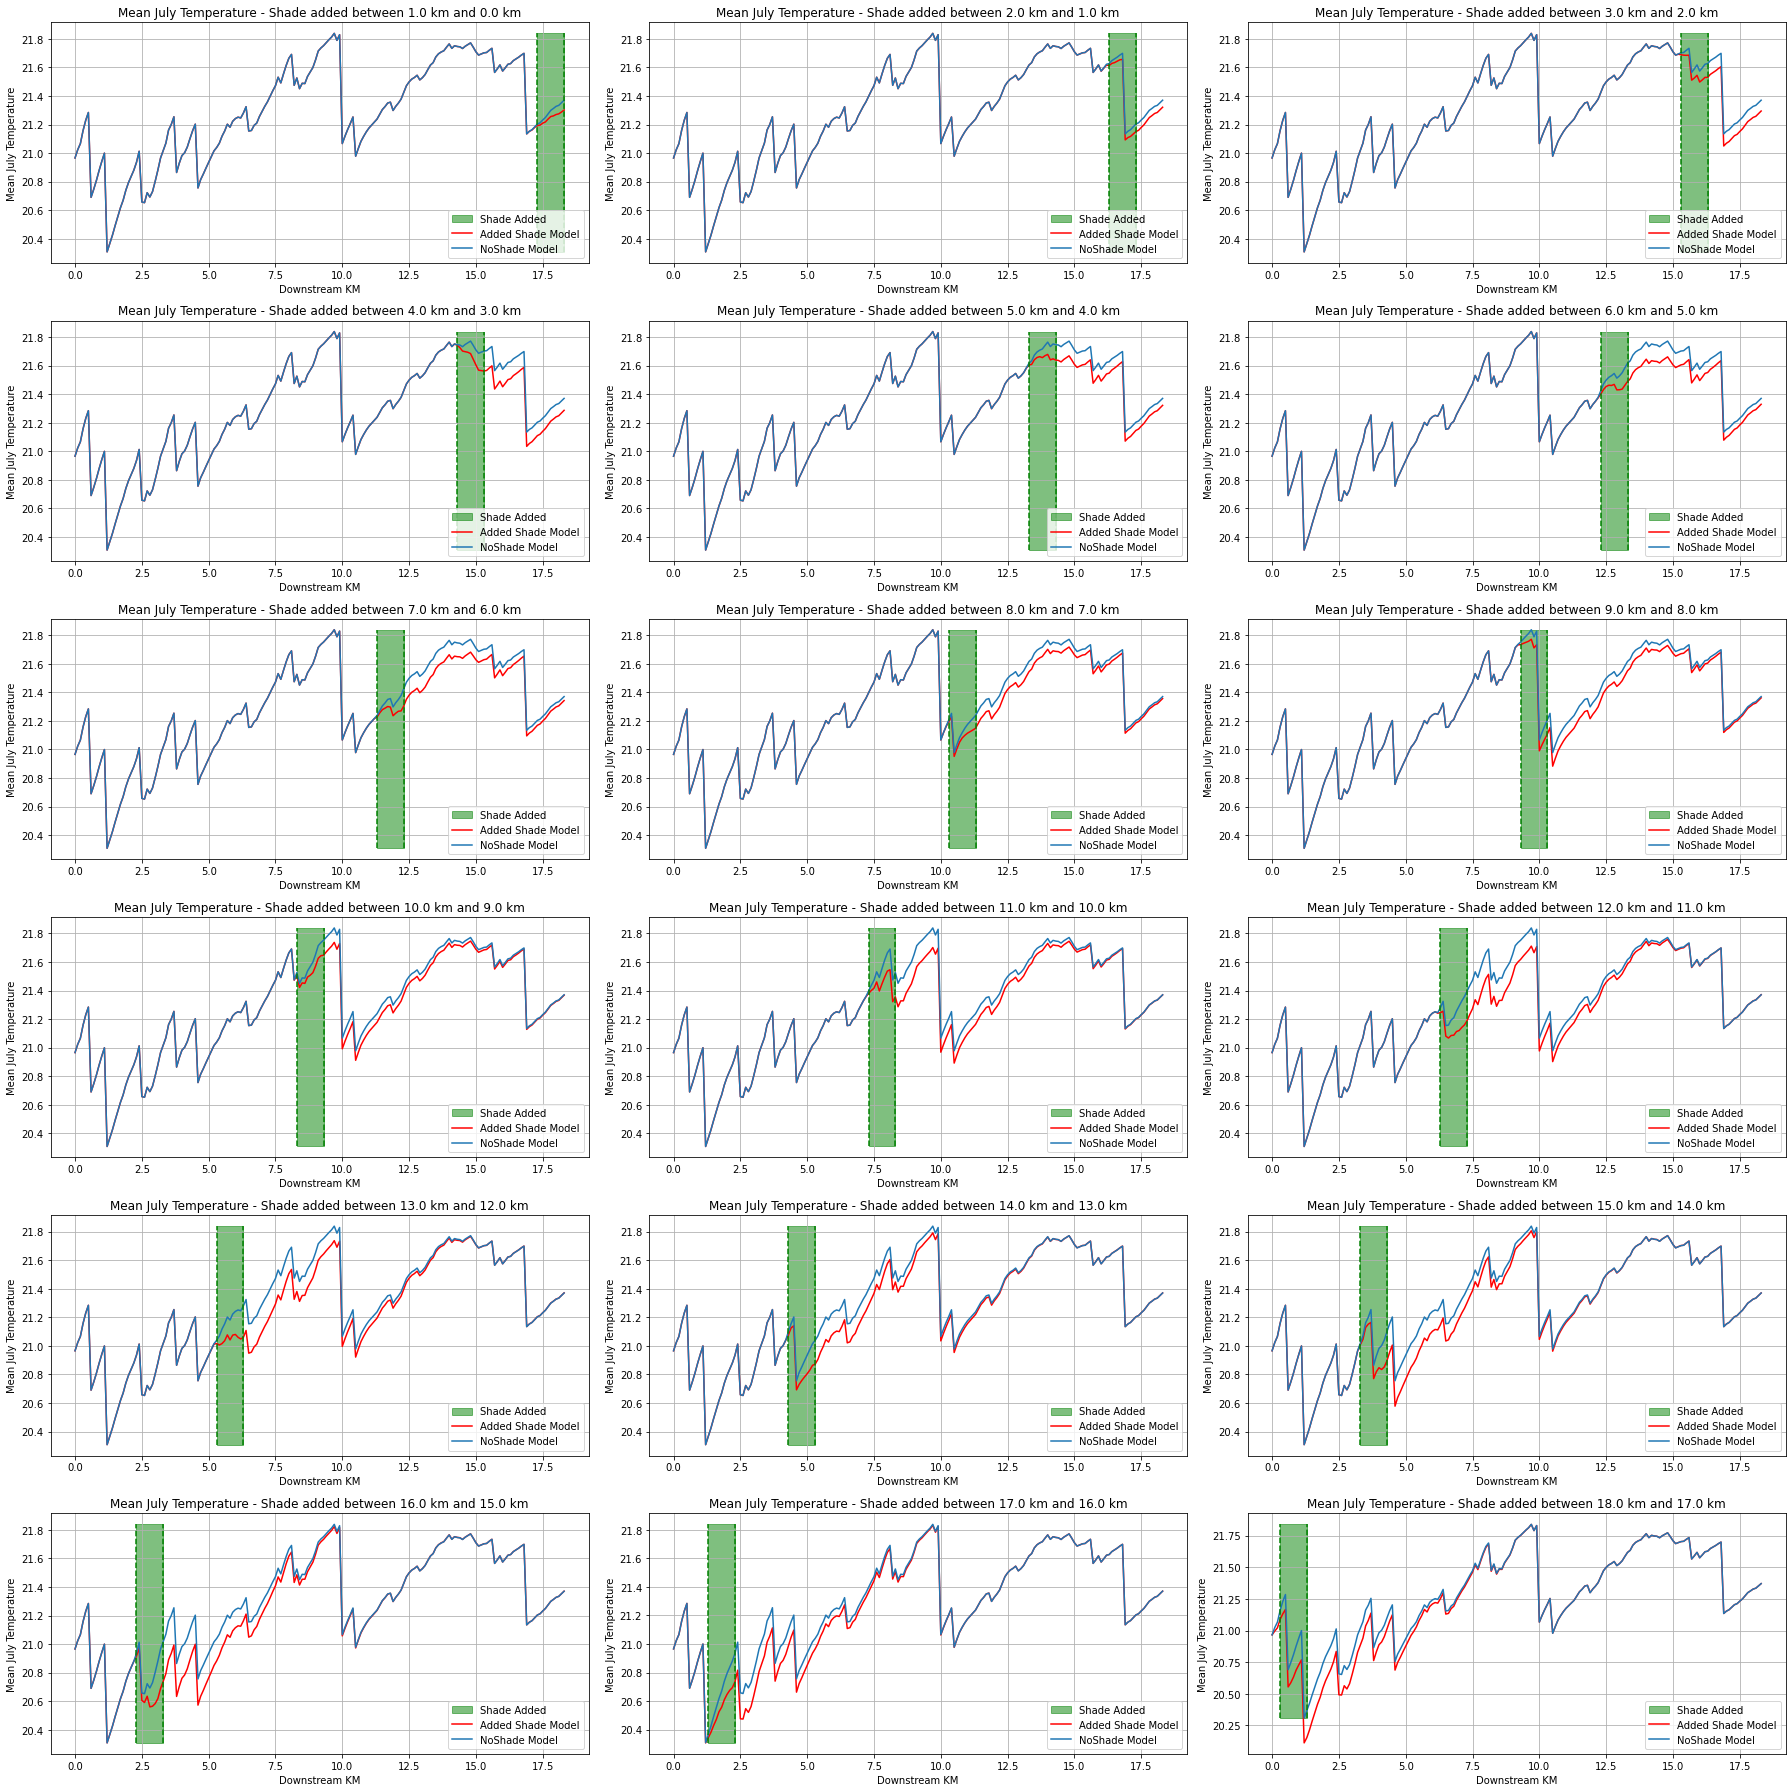

In [22]:
obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(6, 3, figsize=(25, 25))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\grassallnodes', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
#discts to hold differneces between scenarios
effectiveness_difference = {}
norm_effectiveness_difference = {}

for i in range(19):
    km_start = i
    km_end = i-1
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder =  f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\reachbyreach\\addshade_{i}.0'
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        mean_july_modeled
        
        #saving reach effectiveness
        difference = mean_july_modeled - upstreamconstant_modeled
        norm_difference = difference/km_start
        norm_difference = norm_difference.values.sum()
        norm_effectiveness_difference[int(f'{km_start}')] = norm_difference
        effectiveness_difference[int(f'{km_start}')] = difference.values.sum()

        

        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[i-1].fill_between([18.3 - km_start, 18.3 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='green', alpha = .5, label = 'Shade Added')
        axes[i-1].plot(mean_july_modeled.index/10, mean_july_modeled['Mean July Temp'], label=f'Added Shade Model', color = 'red')
        axes[i-1].plot(upstreamconstant_modeled.index/10, upstreamconstant_modeled['Mean July Temp'], label='NoShade Model')
        axes[i-1].set_title(f'Mean July Temperature - Shade added between {km_start}.0 km and {km_end}.0 km')
        axes[i-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[i-1].set_ylabel('Mean July Temperature')  # Replace 'Y Label' with appropriate label


        axes[i-1].vlines([18.3 - km_start, 18.3 - km_end], ymin = upstreamconstant_modeled['Mean July Temp'].min(), ymax = upstreamconstant_modeled['Mean July Temp'].max(),color = 'green', linestyles = 'dashed')
        axes[i-1].grid(True) 
        axes[i-1].legend(loc = 'lower right')

    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

Area between the lines: -387.38099562499997


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], dtype=int64)

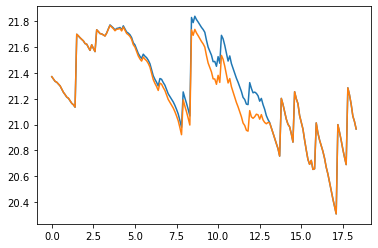

In [51]:
reach_source_folder =  f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\reachbyreach\\addshade_{13}.0'
modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
modeled_tw_df.index = obs_clip.index
# mean july temperature summary
mean_daily_modeled = modeled_tw_df.resample('D').mean()
mean_july_modeled = mean_daily_modeled.mean()    
mean_july_modeled = pd.DataFrame(mean_july_modeled)
mean_july_modeled = mean_july_modeled.reset_index()
mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
mean_july_modeled



upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\grassallnodes', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

upstreamconstant_modeled

plt.plot(upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='base')
plt.plot(mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label='mod')


# # CODE TO Find intersection points (assuming lines intersect)
intersections = np.argwhere(np.isclose(upstreamconstant_modeled['Mean July Temp'].values, mean_july_modeled['Mean July Temp'].values,atol =.1)).flatten()
intersections

# CODE TO FIGURE OUT AREA BETWEEN THE TWO LINES
if len(intersections) >= 2:
    x_intersection_1 = upstreamconstant_modeled['NODE_ID'].iloc[intersections[0]]
    x_intersection_2 = mean_july_modeled['NODE_ID'].iloc[intersections[-1]]
    
    y_intersection_1 = upstreamconstant_modeled['Mean July Temp'].iloc[intersections[0]]
    y_intersection_2 = mean_july_modeled['Mean July Temp'].iloc[intersections[-1]]
    
    area_between = np.trapz([y_intersection_1, y_intersection_2], [x_intersection_1, x_intersection_2])
    print("Area between the lines:", area_between)
else:
    print("Lines do not intersect, cannot calculate area.")
intersections

In [73]:
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\grassallnodes', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
upstreamconstant_df

,18.3,18.2,18.1,18.0,17.9,17.8,17.7,17.6,17.5,17.4,...,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-01 00:00:00,20.817,20.8130,20.8124,20.8095,20.8092,20.8142,20.7433,20.8114,20.8127,20.8120,...,20.8120,20.8137,20.8128,20.8112,20.8117,20.8105,20.8124,20.8090,20.8105,20.8119
2023-07-01 01:00:00,20.484,20.4979,20.5072,20.4958,20.4894,20.5123,19.9274,19.9807,20.0205,20.0680,...,20.3152,20.3482,20.3764,20.3933,20.4123,20.4264,20.4452,20.4509,20.4626,20.4751
2023-07-01 02:00:00,20.150,20.1695,20.1843,20.1800,20.1798,20.2084,19.6384,19.6814,19.7035,19.7208,...,19.9723,19.9912,20.0050,20.0131,20.0233,20.0295,20.0410,20.0419,20.0496,20.0582
2023-07-01 03:00:00,19.841,19.8593,19.8742,19.8702,19.8711,19.9007,19.3431,19.3884,19.4126,19.4317,...,19.7315,19.7425,19.7489,19.7523,19.7580,19.7599,19.7672,19.7648,19.7691,19.7742
2023-07-01 04:00:00,19.484,19.5132,19.5372,19.5434,19.5523,19.5900,19.0459,19.0954,19.1225,19.1441,...,19.5650,19.5706,19.5716,19.5712,19.5729,19.5709,19.5741,19.5682,19.5692,19.5709
2023-07-01 05:00:00,19.246,19.2604,19.2737,19.2694,19.2704,19.2958,18.7542,18.7983,18.8250,18.8481,...,19.4197,19.4244,19.4243,19.4228,19.4234,19.4202,19.4220,19.4148,19.4145,19.4150
2023-07-01 06:00:00,19.032,19.0608,19.0809,19.0949,19.1054,19.1218,18.5742,18.6028,18.6256,18.6469,...,19.3008,19.3074,19.3096,19.3127,19.3170,19.3154,19.3172,19.3113,19.3130,19.3149
2023-07-01 07:00:00,18.889,18.9307,18.9611,19.0044,19.0380,19.0689,18.5245,18.5559,18.5862,18.6185,...,19.2661,19.2766,19.2831,19.2931,19.3047,19.3074,19.3119,19.3101,19.3172,19.3243
2023-07-01 08:00:00,18.937,18.9674,18.9896,19.0625,19.1144,19.1357,18.5863,18.6114,18.6544,18.7038,...,19.3311,19.3452,19.3575,19.3766,19.3953,19.4028,19.4088,19.4052,19.4142,19.4259


In [71]:
rolling_avgrolling_avg = upstreamconstant_df.rolling(window=1, min_periods=1).mean()

# Count the number of days where the rolling average is above 22
above_22_count = (rolling_avg > 21).sum(axis=1)

# Add the above_22_count column to the DataFrame
upstreamconstant_df['above_22_count'] = above_22_count
above_22_count

0      0
1      0
2      0
3      0
4      0
      ..
179    1
180    1
181    1
182    1
183    1
Length: 184, dtype: int64

In [79]:
days_above_21 =upstreamconstant_df.apply(lambda col: (col > 19).sum())
print(days_above_21)

18.3              22
18.2              22
18.1              22
18.0              24
17.9              24
                  ..
0.3               24
0.2               24
0.1               24
0.0               24
above_22_count     0
Length: 185, dtype: int64
